<a href="https://colab.research.google.com/github/DeeeTeeee/NLP/blob/main/FineTuning_DistilBert_Poem_Sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install nlp library
#!pip install transformers wordcloud umap-learn plotly nltk nlp datasets
#!pip install torch

In [3]:
#import libraries for nlp:
import pandas as pd
import numpy as np
from transformers import pipeline
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp
from datasets import load_dataset
from transformers import AutoTokenizer


import torch
import torch.nn.functional as F

In [4]:
#import poem - sentiments dataset from huggingface:
ds_original_from_hf = load_dataset("poem_sentiment")
ds_original_from_hf

Generating train split:   0%|          | 0/892 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/105 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/104 [00:00<?, ? examples/s]

Dataset poem_sentiment downloaded and prepared to /root/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [7]:
train_ds = ds_original_from_hf['train']
train_ds

Dataset({
    features: ['id', 'verse_text', 'label'],
    num_rows: 892
})

In [10]:
#check the labels in the dataset in the features section:
label_names = ds_original_from_hf['train'].features['label'].names
label_names

['negative', 'positive', 'no_impact', 'mixed']

In [15]:
#check the length of the dataset in the train_ds:
len(('train_ds'))
train_ds[0]

{'id': 0,
 'verse_text': 'with pale blue berries. in these peaceful shades--',
 'label': 1}

In [18]:
#check thhe columns names of the train_ds;
ds_original_from_hf['train'].column_names

['id', 'verse_text', 'label']

In [19]:
#check the features of the train_ds:
ds_original_from_hf['train'].features

{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}

In [21]:
#check two rows from the dataset:
train_ds[:5]

{'id': [0, 1, 2, 3, 4],
 'verse_text': ['with pale blue berries. in these peaceful shades--',
  'it flows so long as falls the rain,',
  'and that is why, the lonesome day,',
  'when i peruse the conquered fame of heroes, and the victories of mighty generals, i do not envy the generals,',
  'of inward strife for truth and liberty.'],
 'label': [1, 2, 0, 3, 3]}

In [23]:
#check two rows from verse_text column in the train_ds:
train_ds['verse_text'][0:2]

['with pale blue berries. in these peaceful shades--',
 'it flows so long as falls the rain,']

In [28]:
#create a dataframe from the dataset with no index column:
train = pd.DataFrame(ds_original_from_hf['train'], index=None)
train.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


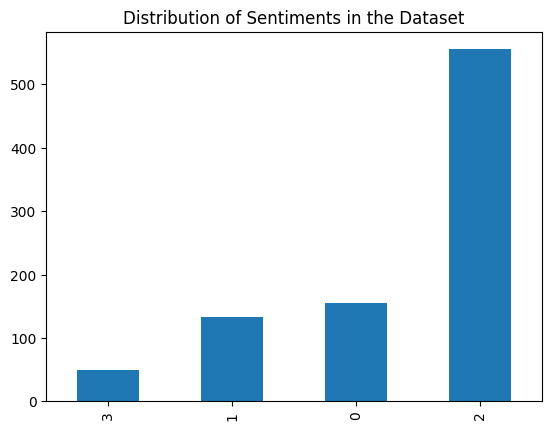

In [30]:
#create a bar chart to show the distribution of the sentiments in the dataset:
train['label'].value_counts(ascending= True).plot(kind='bar', title='Distribution of Sentiments in the Dataset');

## Tokenize

In [33]:
#let create the tokenizer and pre train model:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [34]:
#print for inspecting the vocab size, model max context size and feature names:
print('tokenizer vocab size:', tokenizer.vocab_size)
print('model max length:', tokenizer.model_max_length)
print('feature names:', tokenizer.model_input_names)


tokenizer vocab size: 30522
model max length: 512
feature names: ['input_ids', 'attention_mask']


In [35]:
#def method to tokenize the actual dataset:
def tokenize(batch):
    return tokenizer(batch['verse_text'], padding=True, truncation=True)

In [36]:
#check the first 2 elements in the original dataset:
print(tokenize(ds_original_from_hf['train'][:2]))

{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}
